## **COMP1816 Coursework - Iustin-Andrei Moisa-Tudor - Student ID 001228763**

# **Part 1: Regression (COMP1816_Housing_Dataset_Regression)**

For this part, the main model (or best performing model) will be Ridge regression, and Linear regression + Lasso regression will be the base line models.





# **1.1: Import Libraries**






In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# **1.2 - Load the dataset and run an EDA (Exploratory data analysis)  on the first couple rows**

In [99]:
dataset = pd.read_csv('/content/drive/MyDrive/COMP1816_Housing_Dataset_Regression.csv')

dataset.head()
print(dataset.head())
print("\nShape of the house dataset:", dataset.shape)

   No.  longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    1    -122.12     37.70                  17         2488           617.0   
1    2    -122.21     38.10                  36         3018           557.0   
2    3    -122.22     38.11                  43         1939           353.0   
3    4    -122.20     37.78                  52         2300           443.0   
4    5    -122.19     37.79                  50          954           217.0   

   population  households  median_income  median_house_value ocean_proximity  
0        1287         538         2.9922              179900        NEAR BAY  
1        1445         556         3.8029              129900        NEAR BAY  
2         968         392         3.1848              112700        NEAR BAY  
3        1225         423         3.5398              158400        NEAR BAY  
4         546         201         2.6667              172800        NEAR BAY  

Shape of the house dataset: (1000, 11)


# **1.3 - Preprocess and clean data**

Now that the data is displayed with each column name and data, missing values need to be handled by dropping data

In [100]:
dataset = dataset.dropna()

Some of the categorical values (specificaly the ocean_proximity data)  will be converted to normal numercial values for ease of use and easier understanding for the model. They data will converted to values from 0 - 3

In [101]:
oceanProximityConverted = {
    'NEAR BAY': 0,
    '<1H OCEAN': 1,
    'INLAND': 2,
    'NEAR OCEAN': 3
}
dataset['ocean_proximity'] = dataset['ocean_proximity'].map(oceanProximityConverted)

The rooms by household were divided to get an average of rooms per house, same for bedrooms to distinguish which of the rooms are bedrooms, and population helps show the average number of people per household

In [102]:
dataset['roomsHousehold'] = dataset['total_rooms'] / dataset['households']
dataset['bedrooms_Room'] = dataset['total_bedrooms'] / dataset['total_rooms']
dataset['population_House'] = dataset['population'] / dataset['households']

The squared median income and house age are done to capture any non-linear relationships between income and house prices which may affect model performance

In [103]:
dataset['median_income_squared'] = dataset['median_income'] ** 2
dataset['housing_median_age_squared'] = dataset['housing_median_age'] ** 2

After which, log transformations are applied to the data so that it can make their highly skewed distributions more normal, and np.log1p() is used instead of np.log() because it safely handles zero values in the data

In [104]:
dataset['log_total_rooms'] = np.log1p(dataset['total_rooms'])
dataset['log_total_bedrooms'] = np.log1p(dataset['total_bedrooms'])
dataset['log_population'] = np.log1p(dataset['population'])
dataset['log_households'] = np.log1p(dataset['households'])

train_test_split was imported from the SKlearn library to split the dataset into a train and test split and scale features of X-train and X-text.


In [105]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


X = dataset.drop(['median_house_value'], axis=1)
y = dataset['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTrain shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)


Train shape: (784, 19)
Test shape: (197, 19)


# **1.4 - Training the (Base Line) Linear Regression Model on X_train_scaled and y_train and importing the libraries needed**

In [106]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

Use GridSearch CV to experiment with different parameters (fit_intercept and positive) values for linear regression, then the model can chose the best one to use

In [134]:
linear_hyperparameters = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

linear_search = GridSearchCV(
    LinearRegression(),
    linear_hyperparameters,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

linear_search.fit(X_train_scaled, y_train)


linear = linear_search.best_estimator_
print(f"Best parameters: {linear_search.best_params_}")

Best parameters: {'fit_intercept': True, 'positive': False}


In [139]:

linear.fit(X_train_scaled, y_train)

LinearRegression()

Making prediction on the test set (X_test_scaled)

In [140]:
linearPredictions = linear.predict(X_test_scaled)

Comparing the result with the initial y_test set and calculating the mean squared error and R2 score using scikit learn

In [141]:
linear_mse = mean_squared_error(y_test, linearPredictions)
linear_r2 = r2_score(y_test, linearPredictions)

In [138]:
print("Linear Regression: ")
print(f"MSE: {linear_mse:.2f}")
print(f"R² Score: {linear_r2:.4f}")


Linear Regression: 
MSE: 5770091450.21
R² Score: 0.5505


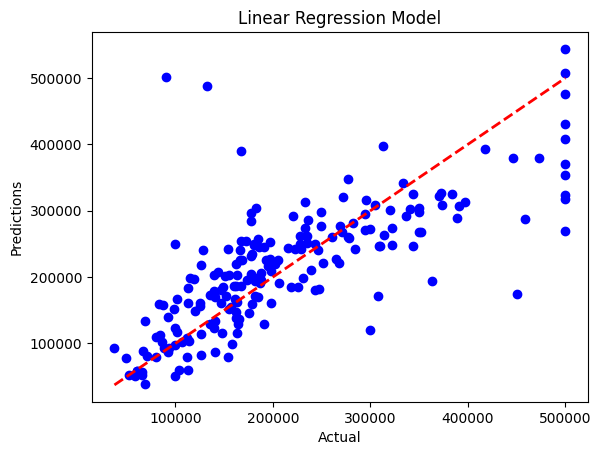

In [111]:
plt.scatter(y_test, linearPredictions, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.title('Linear Regression Model')
plt.show()

# **1.5 - Training the (Base line) Lasso Regression Model on X_train_scaled and y_train**



An array of learning rates from 0.001 to 1.0 in floating point values was chosed so the model can chose the best value for the "alpha" also known as learning rate

In [112]:
lasso_learningrates = {
    'alpha': [0.0001, 0.001, 0.9, 0.12, 0.01, 0.1, 1.0],
    'max_iter': [10000],
    'tol': [0.001]
}

lasso = Lasso(alpha=0.1, max_iter=10000, tol=0.001)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1, max_iter=10000, tol=0.001)

Perform the grid search using the Lasso model and chose best learning rate:

In [113]:
lasso_search = GridSearchCV(
    Lasso(),
    lasso_learningrates,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
lasso_search.fit(X_train_scaled, y_train)

lasso = lasso_search.best_estimator_
print(f"Best Learning Rate: {lasso_search.best_params_['alpha']}")

Best Learning Rate: 1.0


Predicting the output of the model using the predict method and passing the X-test_scaled test set to the lasso model, then calculating it's square error and r2 score

In [114]:
lassoPredictions = lasso.predict(X_test_scaled)


lasso_mse = mean_squared_error(y_test, lassoPredictions)
lasso_r2 = r2_score(y_test, lassoPredictions)

Printing the Results for the Lasso Regression model

In [115]:
print("Lasso Regression: ")
print(f"MSE: {lasso_mse:.2f}")
print(f"R² Score: {lasso_r2:.4f}")

Lasso Regression: 
MSE: 5757926624.87
R² Score: 0.5515


Plotting the results and line of fit of the actual and predicted values using matplotlib

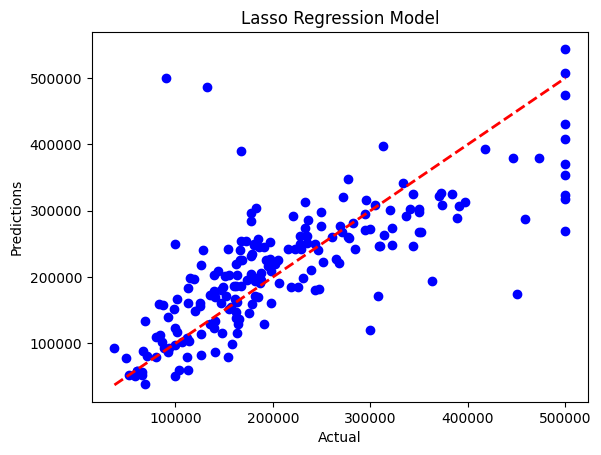

In [116]:
plt.scatter(y_test, lassoPredictions, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.title('Lasso Regression Model')
plt.show()

# **1.6 - Training the (Main) Ridge Regression Model on X_train_scaled and y_train**

An array of learning rates from 0.001 to 1.0 in floating point values was chosed so the model can chose the best value for the "alpha" also known as learning rate

In [117]:
learningrates = [0.001, 0.01, 0.1, 1.0]
ridge_learningrates = {'alpha': learningrates}

Next up, the ridge model will perform a Grid Search so that it can shuffle through the learning rates and chose the best on out of the ones listed above. This is done using Scikit learn's GridSearchCV method. Then train the model by fitting the X and Y training samples to the updated ridge regression model which will use the best learning rate

In [118]:
ridge_search = GridSearchCV(
    Ridge(),
    ridge_learningrates,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
ridge_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0]}, scoring='r2')

Print the best learning rate for the model

In [119]:
ridge = ridge_search.best_estimator_
print(f"Best Ridge Learning Rate: {ridge_search.best_params_['alpha']}")

Best Ridge Learning Rate: 1.0


After which the model will be used for predictions on the X_test_scaled test set.
And it will use the same error and evaluations metrics as the other 2 baseline models. Those being MSE and R2 Score





In [120]:
ridge_pred = ridge.predict(X_test_scaled)

ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

Printing the results of the evaluation and error margin

In [121]:
print("Ridge Regression:")
print(f"MSE: {ridge_mse:.2f}")
print(f"R² Score: {ridge_r2:.4f}")

Ridge Regression:
MSE: 5036365368.79
R² Score: 0.6077


Plotting the prediction of the ridge model with Actual and Predicted values and a line of fit to analyse if the model fits the dataset.

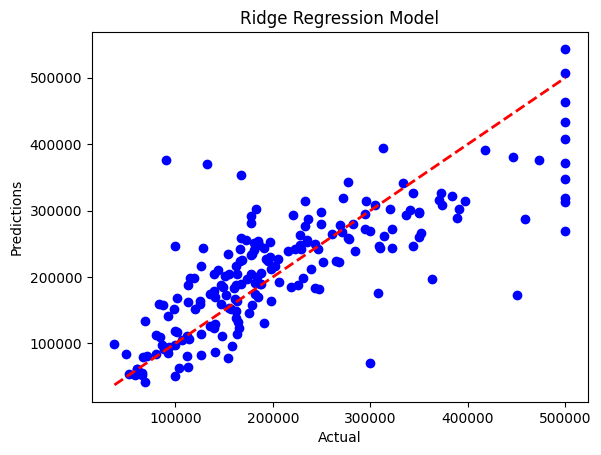

In [122]:
plt.scatter(y_test, ridge_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predictions')
plt.title('Ridge Regression Model')
plt.show()


Below are some visual comparisons between the 3 models comparing their evaluation and MSE scores on visual plots

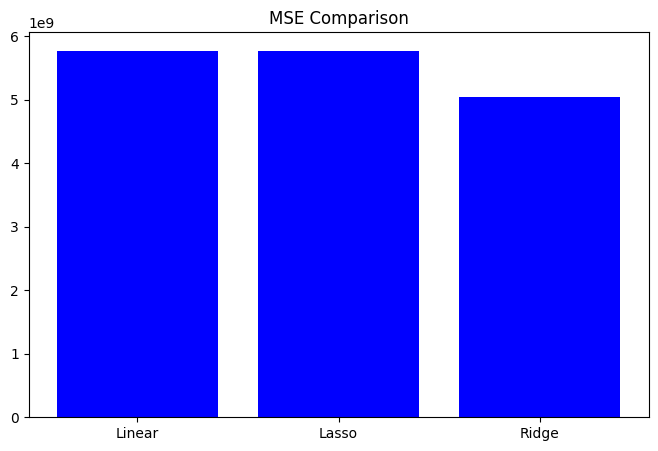

In [123]:
plt.figure(figsize=(8, 5))

plt.bar(['Linear', 'Lasso', 'Ridge'],
        [linear_mse, lasso_mse, ridge_mse],
        color='blue')
plt.title('MSE Comparison')
plt.show()

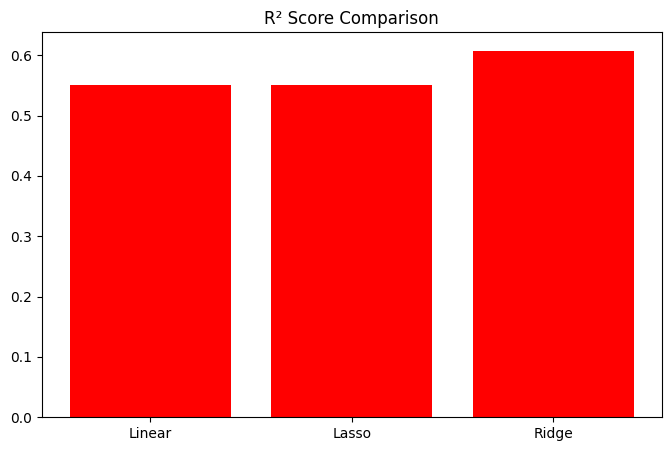

In [124]:
plt.figure(figsize=(8, 5))

plt.bar(['Linear', 'Lasso', 'Ridge'],
        [linear_r2, lasso_r2, ridge_r2],
        color='red')
plt.title('R² Score Comparison')

plt.show()


# **Part 2: Classification (COMP1816_Titanic_Dataset_Classification)**

# **2.1 : Import modules**

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# **2.2 : Load dataset and perform EDA**

In [148]:
dataset = pd.read_csv('/content/drive/MyDrive/COMP1816_Titanic_Dataset_Classification.csv')

Print the first rows of the dataset

In [151]:
print(dataset.head())
print("Shape:", dataset.shape)

   PassengerId  Pclass                                          Name     Sex  \
0            1     3.0                       Braund, Mr. Owen Harris    male   
1            2     1.0                                           NaN  female   
2            3     3.0                        Heikkinen, Miss. Laina  female   
3            4     1.0  Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4            5     3.0                      Allen, Mr. William Henry    male   

    Age  SibSp  Parch        Ticket No.     Fare Embarked  Survival  
0  22.0    1.0    0.0         A/5 21171   7.2500        S       0.0  
1  38.0    1.0    0.0          PC 17599  71.2833        C       1.0  
2  26.0    0.0    0.0  STON/O2. 3101282   7.9250        S       1.0  
3  35.0    1.0    0.0            113803  53.1000        S       1.0  
4  35.0    0.0    0.0            373450   8.0500        S       0.0  
Shape: (890, 11)


Create a copy of the dataset and handle missing values

In [152]:
dataset = dataset.copy()



*   For any SibSp/Parch/Survival **data** rows with missing values, replace with 0s
*   Fill the missing values for Age and Fare with their mean for the specific
columns.

In [153]:
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].mean())
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())
dataset['Pclass'] = dataset['Pclass'].fillna(dataset['Pclass'].mode()[0])
dataset['SibSp'] = dataset['SibSp'].fillna(0)
dataset['Parch'] = dataset['Parch'].fillna(0)
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
dataset['Survival'] = dataset['Survival'].fillna(0)


Creating Data Features:

The FamilySize feature consists of the number of siblings or spouses aboard and parents or children abroad added together + 1 (the actual passenger)

The FarePerPerson feature will have the cost per person, by dividing the total fare for the cruise by the family size feature


In [156]:
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
dataset['FarePerPerson'] = dataset['Fare'] / dataset['FamilySize']

Convert the sex of either female or male to binary represented by 0 or 1 using LabelEncoder

In [157]:
dataset['Sex'] = LabelEncoder().fit_transform(dataset['Sex'])

Create separate binary columns for each category in the "Embarked" (eg: S,C,Q) so it's easier to work with when creating the models

In [158]:
embarkedDummies = pd.get_dummies(dataset['Embarked'], prefix='Embarked')
dataset = pd.concat([dataset, embarkedDummies], axis=1)

Assign the features (collumns) of the dataset to X which will be used as training data and the Survival collumn to Y which will be the probability of the passengers surviving or not

In [160]:
featureColumns = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'FarePerPerson',
           'Embarked_C', 'Embarked_Q', 'Embarked_S']
X = dataset[featureColumns]
y = dataset['Survival']

Get the last 140 data points before shuffling and assign them to X_train, Y_test, Y_train, Y_test

In [161]:
X_train = X.iloc[:-140]
X_test = X.iloc[-140:]
y_train = y.iloc[:-140]
y_test = y.iloc[-140:]

StandardScaler is applied to both X_train and X-test in order to make sure the data has a mean of 0 and standard deviation of 1 which is important for the SVM and Neural Network models

In [162]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **2.3 - Training the Support Vector Machine (SVM) Model on X_train_scaled and y_train**

Starting off by providing some hyperparameter values for the SVM using GridSearchCV.



*   "c" is the regularization parameter to control the possible trade-of maintaining a simple model and getting a low error on the model
*   Both linear and rbf will be used as transformations for the data and experimantation.



In [171]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

parameter_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto']
}

By using 5-fold cross-validation, the model is tested on multiple subsets of the data and GridSearchCV will perform all kinds of tests by mixing the hyperparameters above to find the best parameters.

In [172]:
svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, parameter_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

print(f"Best SVM parameters: {grid_search.best_params_}")
svm_best = grid_search.best_estimator_
svm_pred = svm_best.predict(X_test_scaled)

Best SVM parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


Calculating the accuracy of the SVM model with the chosen hyperparameters using the accuracy_score function in

In [173]:
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM  Results:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(classification_report(y_test, svm_pred))

SVM  Results:
Accuracy: 0.8357
              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88        90
         1.0       0.89      0.62      0.73        50

    accuracy                           0.84       140
   macro avg       0.85      0.79      0.81       140
weighted avg       0.84      0.84      0.83       140



**The SVM Achieved an accuracy score of 83.5%**

# **2.4 - Training the Neural Network Model on X_train_scaled and y_train**

Importing the necessary libraries in tensorflow and keras for creating the neural network classifier

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

The chosen network will be a sequential model with Dense layers of 32 and 16 neurons in size, a dropout is done on the layers so that 20% of the neurons are dropped to prevent overfitting

The most widely used activation fundtion for the hidden layers is ReLu which stands for Rectified Linear Unit and replaces all negative values with zeros which will allow the calculations to be more accurate and the model will perform better.

The output layer is a single dense layer with a neuron and a sigmoid function which is most vwidely used in output layers.

In [177]:

def neuralNetwork_model(input_dim):
    model = Sequential([
        Dense(32, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

Compiling the network is done using the adam optimiser to ensure the best learning rates are chosen automatically and the loss is binary crossentropy since we're dealing with binary classification

The metric used for the neural network model is accuracy which will give a final metric on the precentage of accuracy for the model

In [180]:
nn_model = neuralNetwork_model(X_train_scaled.shape[1])
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])


The  "stop" variable will have an EarlyStopping callback from keras, implemented to stop the training if the validation loss doesnt improve after 10 epochs and restores the best model weights to stop overfitting.

The model is then fitted with the training x and y data, and trained on 100 epochs with a batch size of 32 and callback "stop" mentioned above is implemented

In [182]:
stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = nn_model.fit(X_train_scaled, y_train,
                      validation_split=0.2,
                      epochs=100,
                      batch_size=32,
                      callbacks=[stop],
                      verbose=0)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


the neural network is then used to predict hte scaled X-Test testing set and calculate the accuracy using accuracy_score from sklearn.metrics

In [183]:

nn_pred = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
nn_accuracy = accuracy_score(y_test, nn_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


The accuracy and results of the neural network are printed below

In [185]:
print("Neural Network Results:")
print(f"Accuracy: {nn_accuracy:.4f}")
print(classification_report(y_test, nn_pred))

Neural Network Results:
Accuracy: 0.8286
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87        90
         1.0       0.80      0.70      0.74        50

    accuracy                           0.83       140
   macro avg       0.82      0.80      0.81       140
weighted avg       0.83      0.83      0.83       140



**The Neural Network Achieved an accuracy score of 82.8%**

# **2.5 - Training the Decision Tree Classifier Model on X_train_scaled and y_train**

Libraries were imported previously

First step is creating the hyperparameters for the GridSearchCV to experiment with and chose the best one

max_depth will limit the depth a tree can go to prevent overfitting (added as positive numbers 2-8)

the min_samples_split will tell the tree how many samples until a branch splits, and the criterion will chose how to split the nodes

In [187]:
parameters = {
    'max_depth': [2, 4, 6, 8,10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['entropy', 'gini']
}

In [188]:
from sklearn.tree import DecisionTreeClassifier

The model will then be sitted with the training data and will test out and experiment with the different combinations of hyperparameters in order to find the highest performing parameters

In [190]:
decisionTree = DecisionTreeClassifier(random_state=42)
decisionTree_grid_search = GridSearchCV(decisionTree, parameters, cv=5, scoring='accuracy')
decisionTree_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

Print the best parameters for the model

In [195]:
print(f"Best parameters: {decisionTree_grid_search.best_params_}")
dt_best = decisionTree_grid_search.best_estimator_
dt_pred = dt_best.predict(X_test_scaled)

Best parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}


Just like the other 2 models, the accuracy will be calculated using the y-test and prediction of the Decision Tree Classifier and pass those arguments to accuracy_score method of sklearn.metrics

In [196]:
decisionTreeAccuracy = accuracy_score(y_test, dt_pred)
print("Decision Tree Results:")
print(f"Accuracy: {decisionTreeAccuracy:.4f}")
print(classification_report(y_test, dt_pred))

Decision Tree Results:
Accuracy: 0.8714
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        90
         1.0       0.82      0.82      0.82        50

    accuracy                           0.87       140
   macro avg       0.86      0.86      0.86       140
weighted avg       0.87      0.87      0.87       140



**The Decision Tree Model has achieved a score of 87.1%**

# **Overall, the best model out of all 3 classification models is the main model: Decision Tree Classifier.**